# The long wait

* [Libraries ](#Libraries)
* [Data loading, visualization and exploratory analysis](#data)
* [Modeling](#Modeling)
    * [Baseline Estimate](#Baseline)
    * [Logistic Regression](#Logistic-Regression)
    * [Tree Models](#Tree-Models)
        * [Decision Tree](#Decision-Tree-Classifier)
        * [Random Forest](#Random-Forest-Classifier)
        * [AdaBoost](#AdaBoost-Classifier)
    * [Neural network model with Keras](#nn)
* [Summary](#Summary)



# Libraries <a id='Libraries'></a>

In [392]:
#The bread and butter:
import pandas as pd
import numpy as np

#Visualizations:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sb

#Statistics:
import scipy.stats as stats

#ML:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score, precision_score,recall_score
from yellowbrick.classifier import ROCAUC
from sklearn.tree import DecisionTreeClassifier
import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense


# Data loading, visualization and exploratory analysis <a id='data'></a>

Data consists of all January 2019 flights downloaded from Kaggle.

In [2]:
path19 = 'https://raw.githubusercontent.com/flikrama/UH-SPE-ML-Bootcamp-Team4-Project2/master/Jan_2019_ontime.csv'
df19 = pd.read_csv(path19)

In [3]:
df19 = df19.drop('Unnamed: 21', axis = 1)

In [4]:
print(df19.shape)
print(df19.describe())
print(df19.dtypes)

(583985, 21)
        DAY_OF_MONTH    DAY_OF_WEEK  OP_CARRIER_AIRLINE_ID  OP_CARRIER_FL_NUM  \
count  583985.000000  583985.000000          583985.000000      583985.000000   
mean       15.960088       3.835626           19983.213168        2537.869334   
std         8.987942       1.921899             377.724638        1821.736145   
min         1.000000       1.000000           19393.000000           1.000000   
25%         8.000000       2.000000           19790.000000         979.000000   
50%        16.000000       4.000000           19977.000000        2114.000000   
75%        24.000000       5.000000           20368.000000        3902.000000   
max        31.000000       7.000000           20452.000000        7439.000000   

       ORIGIN_AIRPORT_ID  ORIGIN_AIRPORT_SEQ_ID  DEST_AIRPORT_ID  \
count      583985.000000           5.839850e+05    583985.000000   
mean        12659.701982           1.265974e+06     12659.470015   
std          1519.405493           1.519403e+05      

In [5]:
# Number of NaN values in df for each column
df19.isna().sum()

DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
OP_UNIQUE_CARRIER            0
OP_CARRIER_AIRLINE_ID        0
OP_CARRIER                   0
TAIL_NUM                  2543
OP_CARRIER_FL_NUM            0
ORIGIN_AIRPORT_ID            0
ORIGIN_AIRPORT_SEQ_ID        0
ORIGIN                       0
DEST_AIRPORT_ID              0
DEST_AIRPORT_SEQ_ID          0
DEST                         0
DEP_TIME                 16352
DEP_DEL15                16355
DEP_TIME_BLK                 0
ARR_TIME                 17061
ARR_DEL15                18022
CANCELLED                    0
DIVERTED                     0
DISTANCE                     0
dtype: int64

In [6]:
# dropped NaN values in df
df19 = df19.dropna()
print(df19.shape)

(565963, 21)


In [7]:
# Number of Unique elements in df
df19.nunique()

DAY_OF_MONTH               31
DAY_OF_WEEK                 7
OP_UNIQUE_CARRIER          17
OP_CARRIER_AIRLINE_ID      17
OP_CARRIER                 17
TAIL_NUM                 5441
OP_CARRIER_FL_NUM        6833
ORIGIN_AIRPORT_ID         346
ORIGIN_AIRPORT_SEQ_ID     346
ORIGIN                    346
DEST_AIRPORT_ID           346
DEST_AIRPORT_SEQ_ID       346
DEST                      346
DEP_TIME                 1438
DEP_DEL15                   2
DEP_TIME_BLK               19
ARR_TIME                 1440
ARR_DEL15                   2
CANCELLED                   1
DIVERTED                    1
DISTANCE                 1451
dtype: int64

In [197]:
#Remove columns which won't be used
df_red = df19.drop([ 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEP_TIME',
       'CANCELLED','ARR_TIME',
       'DIVERTED'], axis = 1)

In [198]:
df_red.head()

DAY_OF_MONTH  DAY_OF_WEEK OP_UNIQUE_CARRIER ORIGIN DEST  DEP_DEL15  \
0             1            2                9E    GNV  ATL        0.0   
1             1            2                9E    MSP  CVG        0.0   
2             1            2                9E    DTW  CVG        0.0   
3             1            2                9E    TLH  ATL        0.0   
4             1            2                9E    ATL  FSM        0.0   

  DEP_TIME_BLK  ARR_DEL15  DISTANCE  
0    0600-0659        0.0     300.0  
1    1400-1459        0.0     596.0  
2    1200-1259        0.0     229.0  
3    1500-1559        0.0     223.0  
4    1900-1959        0.0     579.0

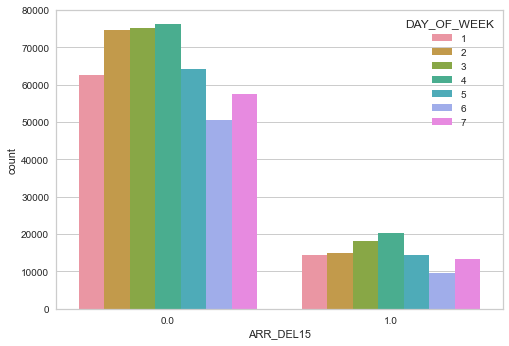

In [163]:
#all delayed flights by weekday
sb.countplot(x = df_red['ARR_DEL15'], hue = df_red['DAY_OF_WEEK'])

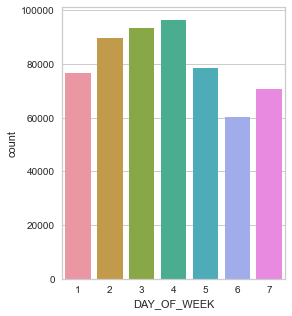

In [164]:
#all flights per day
f, ax = plt.subplots()
sb.countplot(x = df_red['DAY_OF_WEEK'])
f.set_size_inches(4,5)

Seems like we need to normalize the delayed flights per day to the total number of flights per day

Text(0, 0.5, 'Fraction of flights delayed')

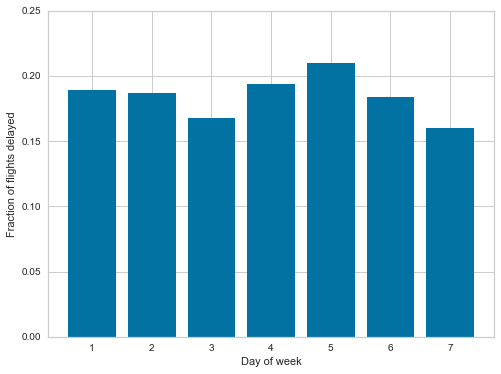

In [165]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6))
plt.bar(x = df_red['DAY_OF_WEEK'].unique(), height = df_red.groupby(['DAY_OF_WEEK'])['ARR_DEL15'].mean())
plt.ylim([0, 0.25])
plt.xlabel('Day of week')
plt.ylabel('Fraction of flights delayed')

Text(0, 0.5, 'Fraction of flights delayed')

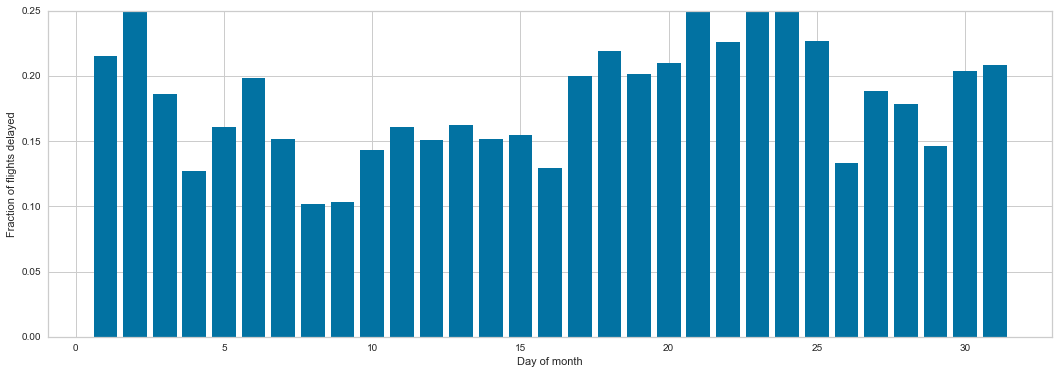

In [404]:
figure(num=None, figsize=(18, 6))
plt.bar(x = df_red['DAY_OF_MONTH'].unique(), height = df_red.groupby(['DAY_OF_MONTH'])['ARR_DEL15'].mean())
plt.ylim([0, 0.25])
plt.xlabel('Day of month')
plt.ylabel('Fraction of flights delayed')

As can be seen the fraction of flights delayed per day looks different from the total delayed flights. Highest proportion is day 5 as opposed to day 4 in raw total numbers

Text(0, 0.5, 'Fraction of flights delayed')

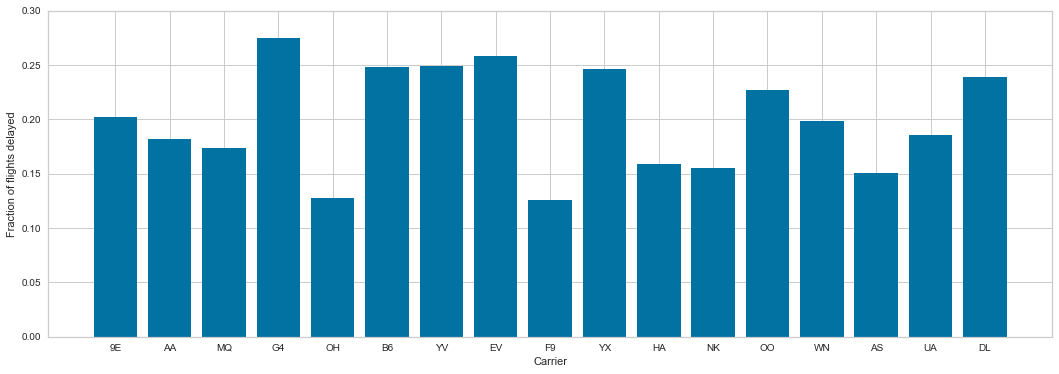

In [202]:
figure(num=None, figsize=(18, 6))
plt.bar(x = df_red['OP_UNIQUE_CARRIER'].unique(), height = df_red.groupby(['OP_UNIQUE_CARRIER']).mean()['ARR_DEL15'])
plt.ylim([0, 0.3])
plt.xlabel('Carrier')
plt.ylabel('Fraction of flights delayed')

Text(0, 0.5, 'Fraction of flights delayed')

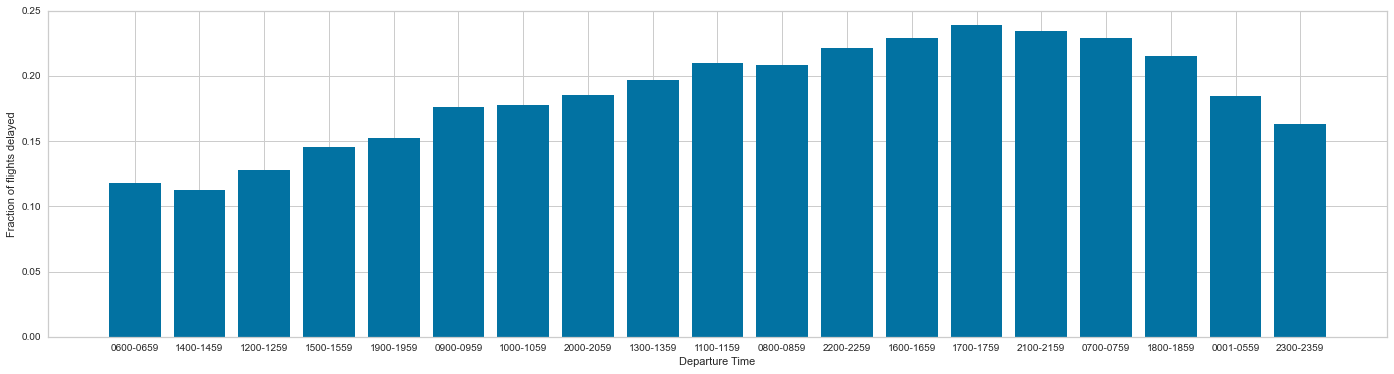

In [203]:
figure(num=None, figsize=(24, 6))
plt.bar(x = df_red['DEP_TIME_BLK'].unique(), height = df_red.groupby(['DEP_TIME_BLK']).mean()['ARR_DEL15'])
plt.ylim([0., 0.25])
plt.xlabel('Departure Time')
plt.ylabel('Fraction of flights delayed')

List below shows what departure time results in most delays proportionally--it can be seen that it's the 1800-18:59 time slot:

Lowest and Highest ratio of delayed flights by Destination shown below; do not fly to Ogden city as you have a 50% chance of being late:

In [205]:
df_red.groupby(['DEST']).mean()['ARR_DEL15'].sort_values()

DEST
ELM    0.000000
CPR    0.044118
LWS    0.047619
DRT    0.050847
BTM    0.051724
         ...   
HGR    0.400000
MKG    0.425532
MMH    0.440000
OGS    0.500000
OGD    0.500000
Name: ARR_DEL15, Length: 346, dtype: float64

Lowest and Highest ratio of delayed flights by Origin shown below; Ogden City again stands out:

In [206]:
#delayed_norm['ORIGIN'] = df_red['ORIGIN']
df_red.groupby(['ORIGIN']).mean()['ARR_DEL15'].sort_values()

ORIGIN
LYH    0.000000
PPG    0.000000
CPR    0.014706
LWS    0.031250
BRW    0.033333
         ...   
ACV    0.429825
VEL    0.434783
OWB    0.444444
OGD    0.500000
OGS    0.600000
Name: ARR_DEL15, Length: 346, dtype: float64

Let us check whether delayed departure translates to also delayed arrival:

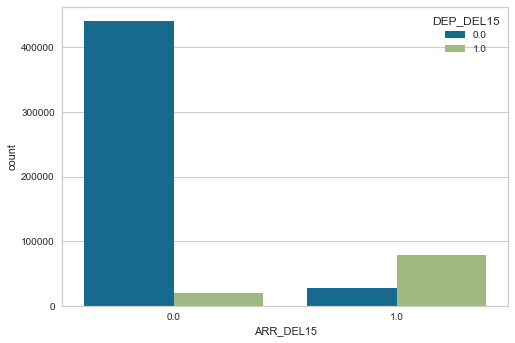

In [207]:
#Check by delay in departure
sb.countplot(x = df_red['ARR_DEL15'], hue = df_red['DEP_DEL15'])

As expected, flights that leave late also (mostly) arrive late. Let us now look at distance traveled below:

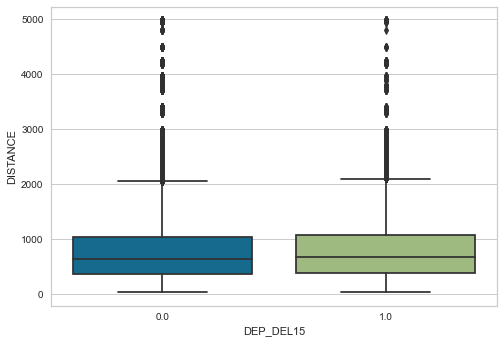

In [208]:
sb.boxplot('DEP_DEL15', 'DISTANCE', data=df_red, orient='v')

In [209]:
df_red.groupby(['DEP_DEL15']).mean()['DISTANCE']

DEP_DEL15
0.0    799.301073
1.0    817.114257
Name: DISTANCE, dtype: float64

In [210]:
df_red.groupby(['DEP_DEL15']).median()['DISTANCE']

DEP_DEL15
0.0    637.0
1.0    674.0
Name: DISTANCE, dtype: float64

There seems to be a slightly higher distance traveled for flights that were delayed. Let us do a t-test to check whether this difference is statistically significant

In [211]:
stats.ttest_ind(df_red[df_red['ARR_DEL15'] == 1]['DISTANCE'], df_red[df_red['ARR_DEL15'] == 0]['DISTANCE'], equal_var=False)

Ttest_indResult(statistic=2.5804047623776594, pvalue=0.009869350308986821)

It is significant!

Finally dummyfying variables for categorical variables: OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST','DEP_TIME_BLK',  'DAY_OF_WEEK and normalizing the 'DISTANCE

In [212]:
df_dum = pd.get_dummies(df_red, columns = ['ORIGIN', 
                                           'DEST', 
                                           'OP_UNIQUE_CARRIER', 
                                           'DEP_TIME_BLK', 
                                           'DAY_OF_WEEK'])

In [213]:
mean = df_dum['DISTANCE'].mean()
std =  df_dum['DISTANCE'].std()
df_dum['DISTANCE'] = (df_dum['DISTANCE'] - mean)/std

In [214]:
df_dum.head()

DAY_OF_MONTH  DEP_DEL15  ARR_DEL15  DISTANCE  ORIGIN_ABE  ORIGIN_ABI  \
0             1        0.0        0.0 -0.848173           0           0   
1             1        0.0        0.0 -0.348448           0           0   
2             1        0.0        0.0 -0.968039           0           0   
3             1        0.0        0.0 -0.978169           0           0   
4             1        0.0        0.0 -0.377149           0           0   

   ORIGIN_ABQ  ORIGIN_ABR  ORIGIN_ABY  ORIGIN_ACT  ...  \
0           0           0           0           0  ...   
1           0           0           0           0  ...   
2           0           0           0           0  ...   
3           0           0           0           0  ...   
4           0           0           0           0  ...   

   DEP_TIME_BLK_2100-2159  DEP_TIME_BLK_2200-2259  DEP_TIME_BLK_2300-2359  \
0                       0                       0                       0   
1                       0                       0                       0   
2                       0                       0                       0   
3                       0                       0                       0   
4                       0                       0                       0   

   DAY_OF_WEEK_1  DAY_OF_WEEK_2  DAY_OF_WEEK_3  DAY_OF_WEEK_4  DAY_OF_WEEK_5  \
0              0              1              0              0              0   
1              0              1              0              0              0   
2              0              1              0              0              0   
3              0              1              0              0              0   
4              0              1              0              0              0   

   DAY_OF_WEEK_6  DAY_OF_WEEK_7  
0              0              0  
1              0              0  
2              0              0  
3              0              0  
4              0              0  

[5 rows x 739 columns]

# Modeling <a id='Modeling'></a>

We will be implementing logistics regresion, decision tree,  random forest and adaboost classifier, to predict whether a flight will be delayed or not. Lastly, neural network by using keras will be used to learn about delays. 

## Baseline <a id='Baseline'></a>

Let us first estimate what a completely random estimate would give us (an estimate that does not rely on data science or machine learning at all)
That is to say if we randomly guessed whether a flight would be late or not what our accuracy would be? Let's first get the proportion of flights that are late:

In [215]:
df_dum[df_dum['ARR_DEL15']==1].shape[0]/df_dum.shape[0]

0.18591674720785634

So if we randomly guessed a flight would be late we'd be correct 18.6% of the time; if we randomly guessed a flight would not be late then we'd be correct 81.4% of the time. 

But there is a stricter baseline...It can be seen that most of the late departures also result in late arrivals. Can we predict our arrival delay just on departure delay? Let's see what fraction of late departures results in late arrivals:

In [403]:
df_red.groupby(['DEP_DEL15']).mean()['ARR_DEL15']

DEP_DEL15
0.0    0.057593
1.0    0.796379
Name: ARR_DEL15, dtype: float64

Only with the knowledge of departure delay if we claimed that it would also arrive late then we'd be correct 79.6% of the time. In reality this is the benchmark we should compare the models to...

## Logistic Regression <a id='Logistic-Regression'></a>

In [216]:
X = df_dum.drop(['ARR_DEL15'], axis = 1)
y = df_dum['ARR_DEL15']

In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5) # 50% training and 50% test

Let's estimate best hyperparameters. Here's all that can be optimized:
    
    penalty='l2',
    
    dual=False,
    
    tol=0.0001,
    
    C=1.0,
    
    fit_intercept=True,
    
    intercept_scaling=1,
    
    class_weight=None,
    
    random_state=None,
    
    max_iter=100,
    
    multi_class='auto',
    
    verbose=0,
    
    warm_start=False,
    
    n_jobs=None,
    
    l1_ratio=None,
    
 We'll work on optimizing C and penalty parameters:

In [250]:
lr_model = LogisticRegression(solver = 'saga', max_iter=1000)
grid={'C':np.logspace(-5,-1,10), 'penalty':['l1','l2']}
lr_model_cv = GridSearchCV(lr_model, grid, cv = 5)
lr_model_cv.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",lr_model_cv.best_params_)
print("accuracy :",lr_model_cv.best_score_)

tuned hyperparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.916277069753559


Let's redefine the model with the best fitting hyperparameters and then fit it to the training data:

In [368]:
lr_model = LogisticRegression(C = lr_model_cv.best_params_['C'], 
                              penalty = lr_model_cv.best_params_['penalty'], 
                              max_iter=1000,
                             solver = 'saga')

lr_model.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=1000, solver='saga')

Let's now look at the results:

In [369]:
pred = lr_model.predict(X_test)

print("Classification:\n",classification_report(y_test, pred, digits=3))

Classification:
               precision    recall  f1-score   support

         0.0      0.943     0.957     0.950    230458
         1.0      0.799     0.744     0.771     52524

    accuracy                          0.918    282982
   macro avg      0.871     0.851     0.860    282982
weighted avg      0.916     0.918     0.917    282982



c:\python37\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


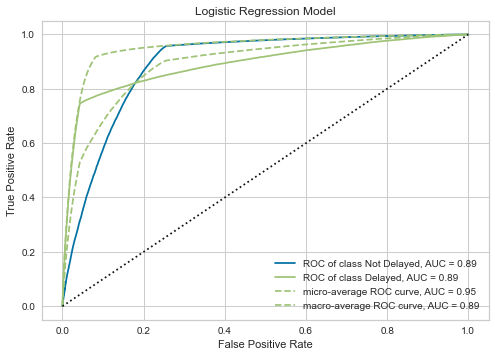

In [370]:
ax = plt.axes()
visualizer = ROCAUC(lr_model, 
                    ax = ax,
                    classes = ['Not Delayed', 'Delayed'])

visualizer.fit(X_train, y_train)         
visualizer.score(X_test, y_test)
ax.set_title('Logistic Regression Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

Let's look at the coefficients of Logistic Regression:

In [255]:
lr_model.coef_[0]

array([ 1.17680386e-02,  4.16667767e+00, -3.06019016e-02,  2.33473318e-01,
        9.26384082e-02, -5.77895991e-02,  3.02209816e-02, -2.12359890e-01,
       -3.30404680e-01,  2.12139086e-01,  1.12542987e-01,  2.07917150e-03,
       -2.77790644e-02,  4.53872338e-01, -1.24157288e-01,  1.75380834e-02,
        6.26055225e-02, -2.73258158e-01, -3.89374157e-01,  1.71151661e-01,
        1.93460300e-01,  5.45746988e-01, -1.57089395e-01,  1.79413487e-01,
       -2.48913865e-01, -1.05350757e-01, -1.49023357e-01,  5.43084241e-02,
       -6.38403861e-03, -1.28088398e-02,  5.35663388e-02,  4.78437976e-02,
        2.74544553e-02,  6.66602482e-02,  9.42814348e-02,  1.07724227e-01,
        4.94719101e-02, -1.79013933e-02,  9.92897984e-02, -1.98879324e-01,
       -6.45435391e-03,  1.58914703e-02, -1.44874409e-01, -3.72157782e-01,
        7.54543976e-02, -1.58823082e-01, -1.65937464e-01, -1.57823900e-01,
        1.83899530e-01,  8.64456079e-02, -2.12098800e-03, -3.33134961e-02,
        3.75096311e-02,  

The 2nd coefficient equal to 4.16667767 belongs to the DEP_DEL_15 which shows us that the largest effect in the arrival delay of a flight is whether is departed late or not (which is what's expected from common sense). However the other coefficients are not negligible.

Let's see and plot the top 5% of the most important features:

In [389]:
top_5_pc = np.percentile(np.abs(lr_model.coef_[0]),95)
importance = pd.Series(lr_model.coef_[0])
features = pd.Series(X.columns)

features_ = pd.concat([features, importance], axis = 1)
features_.rename({0:'Feat', 1: 'Coef'}, axis = 1, inplace = True)
feat = features_[np.abs(features_['Coef']) > top_5_pc]
feat

Feat      Coef
1               DEP_DEL15  4.166678
13             ORIGIN_AEX  0.453873
21             ORIGIN_ASE  0.545742
53             ORIGIN_BTV  0.454379
58             ORIGIN_CAE -0.429692
59             ORIGIN_CAK  0.497402
63             ORIGIN_CHA -0.586228
66             ORIGIN_CID  0.415904
72             ORIGIN_CMH  0.495708
87             ORIGIN_DAL -0.457402
136            ORIGIN_GRR  0.433911
150            ORIGIN_HOU -0.501094
179            ORIGIN_LAN  0.433981
207            ORIGIN_MDW  0.437850
214            ORIGIN_MHT  0.409476
216            ORIGIN_MKE  0.409219
219            ORIGIN_MLI  0.605248
241            ORIGIN_ORD  0.652746
257            ORIGIN_PIE -0.411806
285            ORIGIN_RST  0.450597
300            ORIGIN_SFO  0.681803
314            ORIGIN_SPI  0.429173
333            ORIGIN_TUL -0.528992
367              DEST_ASE  0.557413
383              DEST_BIS  0.478300
449              DEST_EGE  0.654729
458              DEST_EWR  0.587446
515              DEST_ITO -0.699995
523              DEST_KOA -0.628209
538              DEST_LGA  0.771391
540              DEST_LIH -0.505896
576              DEST_MTJ  0.531429
581              DEST_OGG -0.436751
587              DEST_ORD  0.451829
702  OP_UNIQUE_CARRIER_G4  0.482347
703  OP_UNIQUE_CARRIER_HA  0.466599
709  OP_UNIQUE_CARRIER_WN -0.516999

Text(0.5, 0, 'Importance')

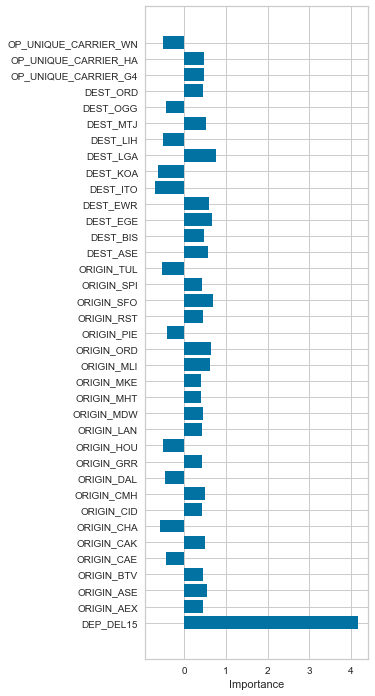

In [390]:
fig,ax = plt.subplots()
fig.set_size_inches(4, 12)
ax.barh(feat.Feat, feat.Coef)
ax.set_xlabel('Importance')

As expected the highest coefficient belongs to the departure delay. It is curious that weekday does not matter; instead the origin airports and unique carriers do.

## Tree Models <a id='Tree-Models'></a>


### Decision Tree Classifier <a id='Decision-Tree-Classifier'></a>

In [260]:
dt_model = DecisionTreeClassifier(random_state = 0)

Let's optimize the hyperparameters. There are many hyperparameters to the Decision Tree as below:

    criterion='gini',

    splitter='best',

    max_depth=None,

    min_samples_split=2,

    min_samples_leaf=1,

    min_weight_fraction_leaf=0.0,

    max_features=None,

    random_state=None,

    max_leaf_nodes=None,

    min_impurity_decrease=0.0,

    min_impurity_split=None,

    class_weight=None,

    presort='deprecated',

    ccp_alpha=0.0

It would take weeks to run all the parameters above. 
Let us just instead play only with max_depth:

In [262]:
grid={'max_depth':[2,6,10]}

dt_model_cv = GridSearchCV(dt_model, grid, cv = 5)

dt_model_cv.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",dt_model_cv.best_params_)
print("accuracy :",dt_model_cv.best_score_)

tuned hyperparameters :(best parameters)  {'max_depth': 2}
accuracy : 0.9162735358100379


Let's redefine the model with the best fitting hyperparameters and then fit it to the training data:

In [263]:
dt_model = DecisionTreeClassifier(random_state = 0, 
                                  max_depth = dt_model_cv.best_params_['max_depth'] )

dt_model.fit(X_train, y_train)

Let's now look at the results:

In [38]:
y_pred = dt_model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.93    230376
         1.0       0.70      0.67      0.68     52606

    accuracy                           0.88    282982
   macro avg       0.81      0.80      0.80    282982
weighted avg       0.88      0.88      0.88    282982



c:\python37\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


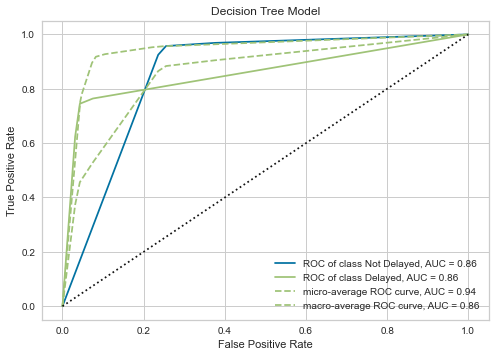

In [264]:
ax = plt.axes()
visualizer = ROCAUC(dt_model, 
                    ax = ax,
                    per_class = True,
                    classes = ['Not Delayed', 'Delayed'])

visualizer.fit(X_train, y_train)         
visualizer.score(X_test, y_test) 
ax.set_title('Decision Tree Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

Let's seet which features are important in Decision Tree model:

In [290]:
importance = pd.Series(dt_model.feature_importances_)
features = pd.Series(X.columns)

features_ = pd.concat([features, importance], axis = 1)
features_.rename({0:'Feat', 1: 'Impo'}, axis = 1, inplace = True)
features_[features_['Impo'] > 0.0]


Feat      Impo
1               DEP_DEL15  0.993692
241            ORIGIN_ORD  0.001336
709  OP_UNIQUE_CARRIER_WN  0.004972

It can be seen that only 3 features matter at all: The expected departure delay, whether Origin is ORD and Carrier is WN

### Random Forest Classifier <a id='Random-Forest-Classifier'></a>

In [302]:
rf_model=RandomForestClassifier()

Let's optimize the hyperparameters. Here's all that can be optimized:

    n_estimators=100,
    
    criterion='gini',
    
    max_depth=None,
    
    min_samples_split=2,
    
    min_samples_leaf=1,
    
    min_weight_fraction_leaf=0.0,
    
    max_features='auto',
    
    max_leaf_nodes=None,
    
    min_impurity_decrease=0.0,
    
    min_impurity_split=None,
    
    bootstrap=True,
    
    oob_score=False,
    
    n_jobs=None,
    
    random_state=None,
    
    verbose=0,
    
    warm_start=False,
    
    class_weight=None,
    
    ccp_alpha=0.0,
    
    max_samples=None,
    
This is a very long list, so let us instead test for max_depth and max_features:

In [303]:
grid = {'max_depth':[2,4,6], 'max_features':["sqrt", "log2"]}

rf_model_cv = GridSearchCV(rf_model, grid, cv = 5)

rf_model_cv.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",rf_model_cv.best_params_)
print("accuracy :",rf_model_cv.best_score_)

tuned hyperparameters :(best parameters)  {'max_depth': 2, 'max_features': 'sqrt'}
accuracy : 0.8137754831753201


Let's redefine the model with the best fitting hyperparameters and then fit it to the training data:

In [307]:
rf_model = RandomForestClassifier(max_depth = rf_model_cv.best_params_['max_depth'],
                                 max_features = rf_model_cv.best_params_['max_features'] )

rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features='sqrt')

Let's now look at the results:

In [339]:
y_pred = rf_model.predict(X_test)
print(metrics.accuracy_score(y_test,y_pred))

0.8143910213370462


c:\python37\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


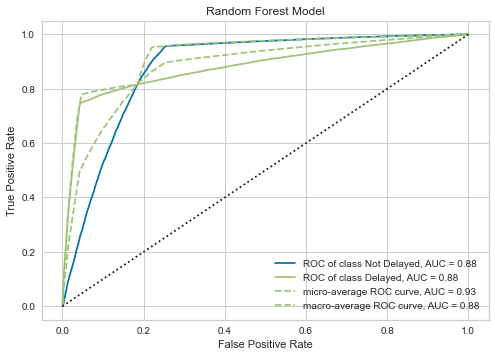

In [309]:
ax = plt.axes()
visualizer = ROCAUC(rf_model, 
                    ax = ax,
                    classes = ['Not Delayed', 'Delayed'])

visualizer.fit(X_train, y_train)         
visualizer.score(X_test, y_test) 
ax.set_title('Random Forest Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

Let's seet which features are important (top 5%) in Decision Tree model:

In [383]:
top_5_pc = np.percentile(rf_model.feature_importances_,95)
importance = pd.Series(rf_model.feature_importances_)
features = pd.Series(X.columns)

features_ = pd.concat([features, importance], axis = 1)
features_.rename({0:'Feat', 1: 'Impo'}, axis = 1, inplace = True)
feat = features_[features_['Impo'] > top_5_pc]
feat

Feat      Impo
0              DAY_OF_MONTH  0.027529
1                 DEP_DEL15  0.094998
2                  DISTANCE  0.005568
21               ORIGIN_ASE  0.020547
22               ORIGIN_ATL  0.015161
112              ORIGIN_EWR  0.014059
192              ORIGIN_LGA  0.033119
207              ORIGIN_MDW  0.008479
219              ORIGIN_MLI  0.010786
233              ORIGIN_OAK  0.004756
241              ORIGIN_ORD  0.042890
298              ORIGIN_SEA  0.010779
300              ORIGIN_SFO  0.010927
368                DEST_ATL  0.036077
390                DEST_BOS  0.010305
458                DEST_EWR  0.060213
538                DEST_LGA  0.056758
587                DEST_ORD  0.042201
600                DEST_PHX  0.019664
646                DEST_SFO  0.016134
698    OP_UNIQUE_CARRIER_B6  0.023626
699    OP_UNIQUE_CARRIER_DL  0.080143
700    OP_UNIQUE_CARRIER_EV  0.005320
701    OP_UNIQUE_CARRIER_F9  0.005014
702    OP_UNIQUE_CARRIER_G4  0.011174
704    OP_UNIQUE_CARRIER_MQ  0.022657
707    OP_UNIQUE_CARRIER_OO  0.025438
709    OP_UNIQUE_CARRIER_WN  0.037339
711    OP_UNIQUE_CARRIER_YX  0.033202
712  DEP_TIME_BLK_0001-0559  0.009761
713  DEP_TIME_BLK_0600-0659  0.043191
714  DEP_TIME_BLK_0700-0759  0.019259
715  DEP_TIME_BLK_0800-0859  0.020494
724  DEP_TIME_BLK_1700-1759  0.017163
725  DEP_TIME_BLK_1800-1859  0.018261
727  DEP_TIME_BLK_2000-2059  0.013562
736           DAY_OF_WEEK_6  0.011664

Let's see the most important features' relative importance graphically:

Text(0.5, 0, 'Importance')

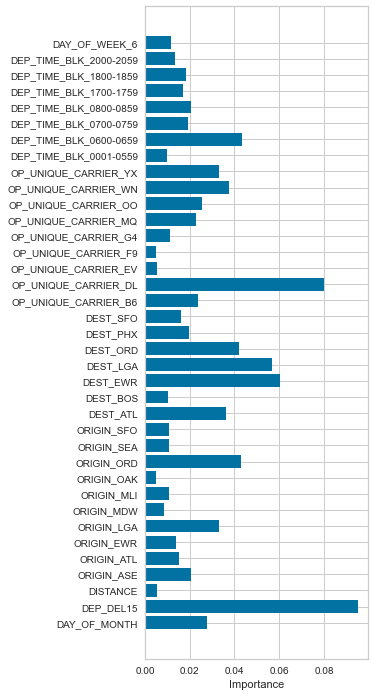

In [385]:
fig,ax = plt.subplots()
fig.set_size_inches(4, 12)
ax.barh(feat.Feat, feat.Impo)
ax.set_xlabel('Importance')

DEP_DEL15's relative importance is as expected! Some destinations and origins and whether it's Saturday or not also matters!!

### AdaBoost Classifier <a id='AdaBoost-Classifier'></a>


In [ ]:
ab_model = AdaBoostClassifier()

Let's optimize the hyperparameters. Here's the hyperparameters to the AdaBoost Classifier as below:
    
    base_estimator=None,
    
    n_estimators=50,
    
    learning_rate=1.0,
    
    algorithm='SAMME.R',
    
    random_state=None

Let's us optimize the learning rate:

In [347]:
grid={'learning_rate':np.logspace(-2,2,5)}

ab_model_cv = GridSearchCV(ab_model, grid, cv = 5)

ab_model_cv.fit(X_train, y_train)

print("tuned hyperparameters :(best parameters) ",ab_model_cv.best_params_)
print("accuracy :",ab_model_cv.best_score_)

c:\python37\lib\site-packages\sklearn\ensemble\_weight_boosting.py:561: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(estimator_weight *
c:\python37\lib\site-packages\sklearn\ensemble\_weight_boosting.py:155: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
c:\python37\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python37\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "c:\python37\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 130, in fit
    sample_weight, estimator_weight, estimato

c:\python37\lib\site-packages\sklearn\ensemble\_weight_boosting.py:561: RuntimeWarning: overflow encountered in exp
  sample_weight *= np.exp(estimator_weight *
c:\python37\lib\site-packages\sklearn\ensemble\_weight_boosting.py:155: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
c:\python37\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\python37\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python37\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "c:\python37\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 130, in fit
    sample_weight, estimator_weight, estimato

tuned hyperparameters :(best parameters)  {'learning_rate': 0.01}
accuracy : 0.9162735358100379


Let's redefine the model with the best fitting hyperparameters and then fit it to the training data:

In [362]:
ab_model = AdaBoostClassifier(learning_rate = ab_model_cv.best_params_['learning_rate'] )

ab_model.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.01)

Let's now look at the results:

In [365]:
y_pred = ab_model.predict(X_test)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95    230458
         1.0       0.80      0.74      0.77     52524

    accuracy                           0.92    282982
   macro avg       0.87      0.85      0.86    282982
weighted avg       0.92      0.92      0.92    282982



c:\python37\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


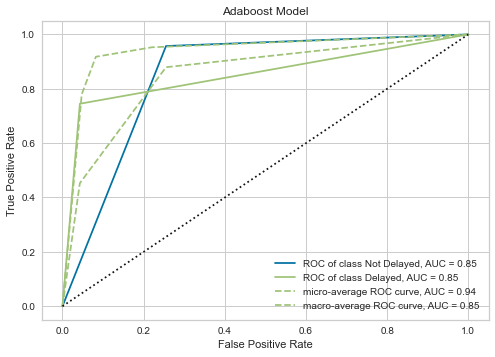

In [371]:
ax = plt.axes()
visualizer = ROCAUC(ab_model, 
                    ax = ax,
                    classes = ['Not Delayed', 'Delayed'])

visualizer.fit(X_train, y_train)         
visualizer.score(X_test, y_test) 
ax.set_title('Adaboost Model')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

Let's seet which features are important:

In [382]:
importance = pd.Series(ab_model.feature_importances_)
features = pd.Series(X.columns)

features_ = pd.concat([features, importance], axis = 1)
features_.rename({0:'Feat', 1: 'Impo'}, axis = 1, inplace = True)
feat = features_[features_['Impo'] > 0.0]
feat

Feat  Impo
1  DEP_DEL15   1.0

Only whether a flight departed late matters!!!

## Neural network model with Keras  <a id='nn'></a>

In [393]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


nn_model_s = Sequential()
nn_model_s.add(Dense(64, input_dim= X_train.shape[1], activation= 'relu'))
nn_model_s.add(Dense(8, input_dim= X_train.shape[1], activation= 'relu'))
nn_model_s.add(Dense(2, activation= 'softmax'))

nn_model_s.compile(loss= 'binary_crossentropy', 
              #optimizer= opt, 
              metrics= ['accuracy'])
history_s = nn_model_s.fit(X_train, y_train,validation_split = 0.5, epochs= 20, batch_size=128)



Epoch 1/20
1106/1106 [==============================] - 16s 15ms/step - loss: 0.2842 - accuracy: 0.9059 - val_loss: 0.2680 - val_accuracy: 0.9175
Epoch 2/20
1106/1106 [==============================] - 9s 8ms/step - loss: 0.2608 - accuracy: 0.9161 - val_loss: 0.2591 - val_accuracy: 0.9175
Epoch 3/20
1106/1106 [==============================] - 9s 8ms/step - loss: 0.2574 - accuracy: 0.9162 - val_loss: 0.2560 - val_accuracy: 0.9170
Epoch 4/20
1106/1106 [==============================] - 10s 9ms/step - loss: 0.2544 - accuracy: 0.9164 - val_loss: 0.2597 - val_accuracy: 0.9150
Epoch 5/20
1106/1106 [==============================] - 9s 9ms/step - loss: 0.2523 - accuracy: 0.9165 - val_loss: 0.2540 - val_accuracy: 0.9166
Epoch 6/20
1106/1106 [==============================] - 10s 9ms/step - loss: 0.2503 - accuracy: 0.9164 - val_loss: 0.2535 - val_accuracy: 0.9168
Epoch 7/20
1106/1106 [==============================] - 12s 10ms/step - loss: 0.2489 - accuracy: 0.9168 - val_loss: 0.2521 - val_acc

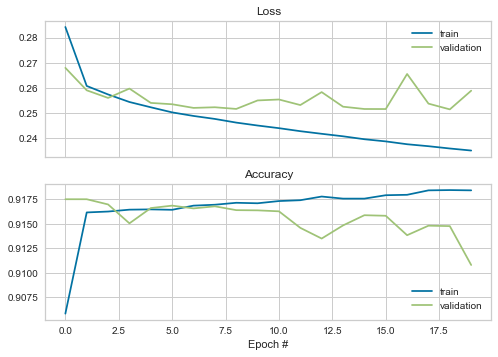

In [394]:
f, (ax1, ax2) = plt.subplots(2,1,sharex= True)
ax1.set_title('Loss')
ax1.plot(history_s.history['loss'], label='train')
ax1.plot(history_s.history['val_loss'], label='validation')
ax1.legend()
# plot accuracy during training
ax2.set_title('Accuracy')
ax2.set_xlabel('Epoch #')
ax2.plot(history_s.history['accuracy'], label='train')
ax2.plot(history_s.history['val_accuracy'], label='validation')
ax2.legend()
plt.show()

Overfitting starts almost immediately however it does not make the prediction accuracy much worse on the validation dataset. 2 epochs are recommended for the model to train.

In [400]:
_, train_acc = nn_model_s.evaluate(X_train, y_train, verbose=0)
_, test_acc = nn_model_s.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.916, Test: 0.913


In [399]:
y_pred = nn_model_s.predict(X_test)
y_pred  = (y_pred > 0.5)
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95    230483
           1       0.80      0.70      0.75     52499

   micro avg       0.91      0.91      0.91    282982
   macro avg       0.87      0.83      0.85    282982
weighted avg       0.91      0.91      0.91    282982
 samples avg       0.91      0.91      0.91    282982



## Summary <a id='Summary'></a>

Exploratory data analysis identifies cyclicity in flight delays with respect to week days and also identifies the biggest offending airlines and airports. It also identifies which departure time is most likely to result in delays.

However none of the models beat the harder baseline, that is if we only that a flight departed late and claimed it'd also arrive late we would have a better estimate than all the model. None of the recall values exceeded 0.796.
Optimizing the hyperparameters of the models presents many difficulties. It is time consuming and in this case did not appear to significantly improve the results. It is also likely that the default values of the Sklearn libraries are very good.

It is very possible that more data would improve the model. However with the amount of data present I'd conclude that a single exploratory, statistical model is better than the machine learning models.